In [1]:
#pip install pandas_datareader
#pip install yfinance

In [2]:
import numpy as np

import pandas_datareader as web
import yfinance as yfin
yfin.pdr_override()

import pandas as pd
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('fivethirtyeight') 

#import pypfopt

In [3]:
#defining time range
from datetime import datetime, timedelta
start_date =  datetime.today() - timedelta(days=365) #Last 365 days
end_date = datetime.today()
#print(start, end)

symbols = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLRE", "XLU", "SPY", "BIL"] #"SPY", "BIL" MUST be final 2 symbols

stock_data = web.get_data_yahoo(symbols, start= start_date, end= end_date)

In [4]:
#print(stock_data)

pct_returns_df = stock_data["Adj Close"].pct_change().apply(lambda x: np.log(1+x))
pct_returns_df.dropna(inplace= True)
#print(pct_returns_df)

excess_returns_df = pct_returns_df.sub(pct_returns_df['BIL'], axis= 0)
print(excess_returns_df)

Symbols          XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Date                                                                                                                                   
2021-08-13  0.000492 -0.002969  0.008200 -0.011977 -0.007598  0.006118 -0.003247  0.000816  0.005325  0.006545  0.006904  0.001709  0.0
2021-08-16  0.001900 -0.004419  0.005994 -0.018366 -0.002377  0.011524  0.003641 -0.004768  0.004725  0.001288  0.006315  0.002571  0.0
2021-08-17 -0.008315 -0.024025  0.000548 -0.010361 -0.007041  0.011764 -0.010879 -0.011576 -0.008320  0.001922  0.000579 -0.006577  0.0
2021-08-18 -0.007653  0.003564 -0.012549 -0.021049 -0.012377 -0.015321 -0.010999 -0.011711 -0.013891 -0.010507 -0.005075 -0.011005  0.0
2021-08-19 -0.000097 -0.006621  0.007798 -0.026513 -0.007666  0.004299 -0.007228 -0.009183  0.009519  0.008153  0.003843  0.001328  0.0
...              ...       ...       ...       .

         Standard Deviation  Mean Excess Return
Symbols                                        
XLC                0.016558           -0.001372
XLY                0.019437           -0.000345
XLP                0.009943            0.000252
XLE                0.021001            0.001939
XLF                0.014056           -0.000351
XLV                0.010626            0.000023
XLI                0.011957           -0.000222
XLB                0.013223           -0.000252
XLK                0.017837           -0.000146
XLRE               0.013304           -0.000041
XLU                0.010931            0.000517
SPY                0.013003           -0.000183
BIL                0.000000            0.000000


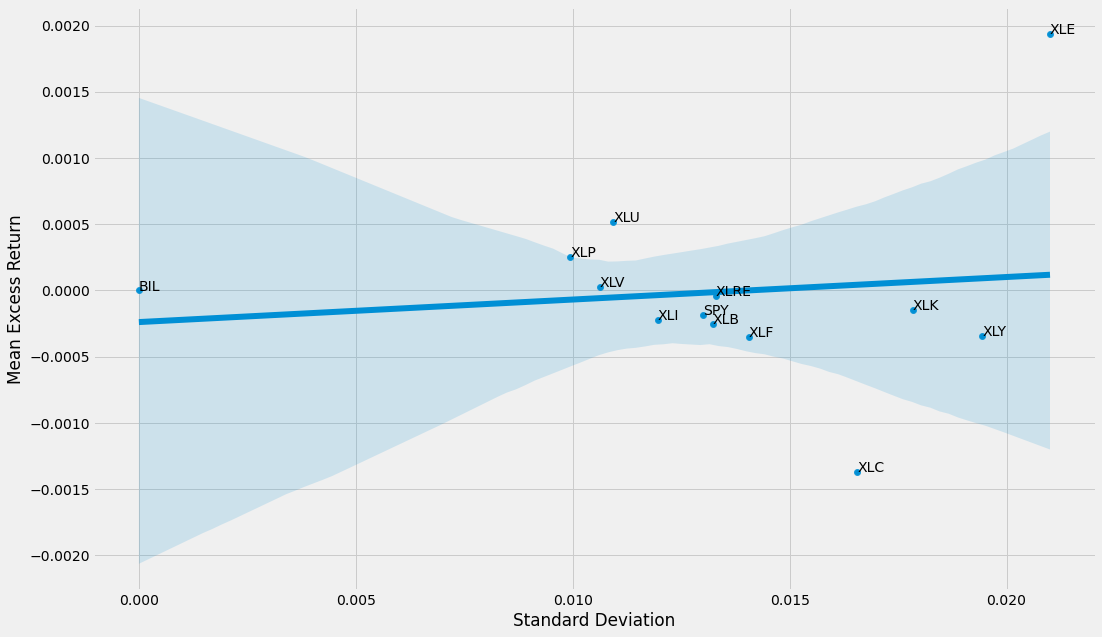

In [5]:
import seaborn as sns

excess_std_mean_df = pd.DataFrame(columns = ['Standard Deviation', 'Mean Excess Return'])
excess_std_mean_df['Standard Deviation'] = excess_returns_df.std()
excess_std_mean_df['Mean Excess Return'] = excess_returns_df.mean()
print(excess_std_mean_df)

excess_std_mean_df.plot(kind = 'scatter', x = 'Standard Deviation', y = 'Mean Excess Return')
for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (excess_std_mean_df['Standard Deviation'][i], excess_std_mean_df['Mean Excess Return'][i]))

#a, b = np.polyfit(excess_std_mean_df['Standard Deviation'], excess_std_mean_df['Mean Excess Return'], 1)
#plt.plot(excess_std_mean_df['Standard Deviation'], a*excess_std_mean_df['Standard Deviation']+b, linestyle = '--', linewidth = 2)

sns.regplot(x= excess_std_mean_df['Standard Deviation'], y= excess_std_mean_df['Mean Excess Return']) #ci= 0
plt.show()

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Symbols                                                                                                                             
XLC      1.000000  0.814680  0.419540  0.251369  0.681375  0.586519  0.721085  0.690853  0.845069  0.557310  0.279037  0.869504  NaN
XLY      0.814680  1.000000  0.458234  0.267347  0.702431  0.556227  0.757922  0.690982  0.884381  0.583037  0.261033  0.900272  NaN
XLP      0.419540  0.458234  1.000000  0.198805  0.565910  0.694142  0.635094  0.595099  0.501246  0.651304  0.659265  0.628676  NaN
XLE      0.251369  0.267347  0.198805  1.000000  0.470893  0.217027  0.476541  0.491631  0.253969  0.281356  0.253296  0.388285  NaN
XLF      0.681375  0.702431  0.565910  0.470893  1.000000  0.638217  0.854574  0.828631  0.709600  0.610876  0.380961  0.837507  NaN
XLV      0.586519  0.556227  0.694142  0.217027  0.638217  1.000000  

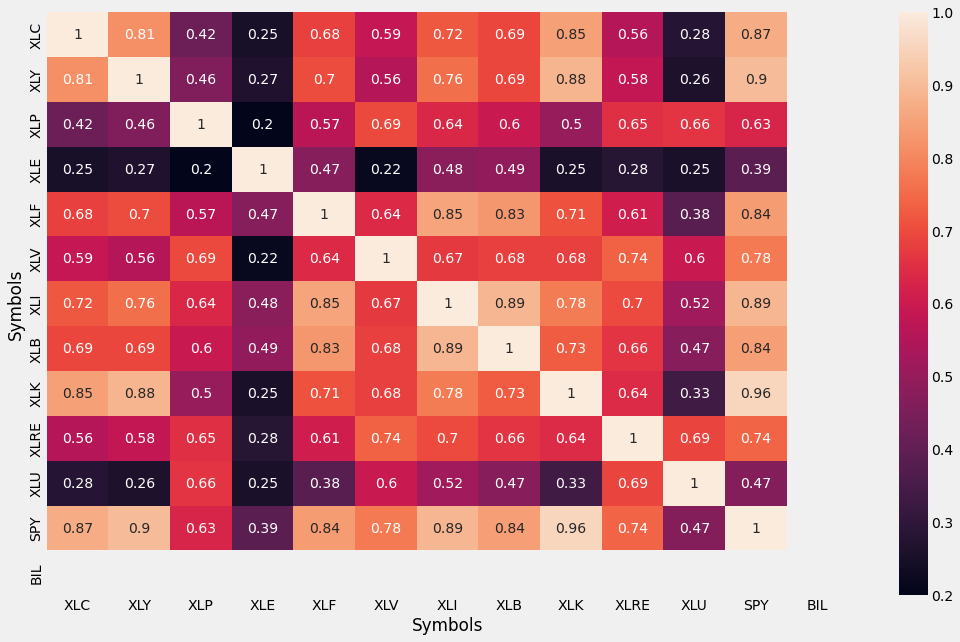

<Figure size 1152x720 with 0 Axes>

In [6]:
corr_matrix_excess = excess_returns_df.corr()
print(corr_matrix_excess)
sns.heatmap(corr_matrix_excess, annot= True)
plt.show()
plt.clf()

In [7]:
from sklearn.linear_model import LinearRegression

excess_returns_df = excess_returns_df.dropna()
betas_df = pd.DataFrame(columns= symbols)
#print(betas_df)
alphas_df = pd.DataFrame(columns= symbols)
#print(expected_returns_df)
alphas_list = []

for column in excess_returns_df:   
    x = np.array(excess_returns_df['SPY']).reshape((-1, 1))
    #print(x)

    y = np.array(excess_returns_df[column])
    #print(y)
    
    model = LinearRegression().fit(x, y)
    alphas_df[column] = pd.Series(model.intercept_)
    betas_df[column] = model.coef_
    #print(column, model.intercept_, model.coef_)
    alphas_list.append(model.intercept_)

alphas_list = alphas_list[:-2]
#print(alphas_list)
print(alphas_df)
print()
print(betas_df)

       XLC       XLY      XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU           SPY  BIL
0 -0.00117 -0.000099  0.00034  0.002054 -0.000186  0.000139 -0.000072 -0.000095  0.000093  0.000097  0.000588  2.710505e-20  0.0

        XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE      XLU  SPY  BIL
0  1.107217  1.345717  0.480703  0.627094  0.905272  0.633395  0.817404  0.855927  1.311167  0.754893  0.39117  1.0 -0.0


In [8]:
hedge_df = excess_returns_df.reset_index()
hedge_df = hedge_df.iloc[:,1:]
#print(hedge_df)

for col in hedge_df:
    for i, row_value in hedge_df[col].iteritems():
        hedge_df[col][i] = hedge_df[col][i] - betas_df[col]*hedge_df["SPY"][i]

hedge_df.drop(index = hedge_df.index[0], axis= 0, inplace= True)
hedge_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
print(hedge_df)

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU
1       -0.000946 -0.007878  0.004759 -0.019978 -0.004704  0.009896  0.001540 -0.006968  0.001354 -0.000653  0.005310
2       -0.001033 -0.015174  0.003710 -0.006236 -0.001088  0.015930 -0.005503 -0.005946  0.000303  0.006886  0.003151
3        0.004533  0.018374 -0.007259 -0.014148 -0.002414 -0.008350 -0.002003 -0.002291  0.000539 -0.002199 -0.000770
4       -0.001568 -0.008409  0.007160 -0.027346 -0.008868  0.003457 -0.008314 -0.010320  0.007777  0.007150  0.003324
5       -0.000156 -0.001105 -0.002159 -0.002789 -0.001054  0.000653 -0.003844 -0.000918  0.002403 -0.001291  0.009274
..            ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
246     -0.010463 -0.014845 -0.001575  0.020601  0.008660  0.000611  0.002905  0.004924 -0.000024  0.004431 -0.003102
247      0.007062  0.006095 -0.000034  0.005874  0.00044

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU
Symbols                                                                                                              
XLC      0.000067  0.000010 -0.000021 -0.000030 -0.000011 -0.000015 -0.000010 -0.000009  0.000004 -0.000019 -0.000023
XLY      0.000010  0.000072 -0.000021 -0.000034 -0.000014 -0.000029 -0.000010 -0.000017  0.000008 -0.000021 -0.000034
XLP     -0.000021 -0.000021  0.000060 -0.000009  0.000006  0.000022  0.000009  0.000009 -0.000018  0.000025  0.000040
XLE     -0.000030 -0.000034 -0.000009  0.000375  0.000043 -0.000019  0.000033  0.000046 -0.000044 -0.000001  0.000017
XLF     -0.000011 -0.000014  0.000006  0.000043  0.000059 -0.000001  0.000018  0.000023 -0.000023 -0.000001 -0.000001
XLV     -0.000015 -0.000029  0.000022 -0.000019 -0.000001  0.000045 -0.000002  0.000004 -0.000011  0.000023  0.000027
XLI     -0.000010 -0.000010  0.000009  0.000033  0.00001

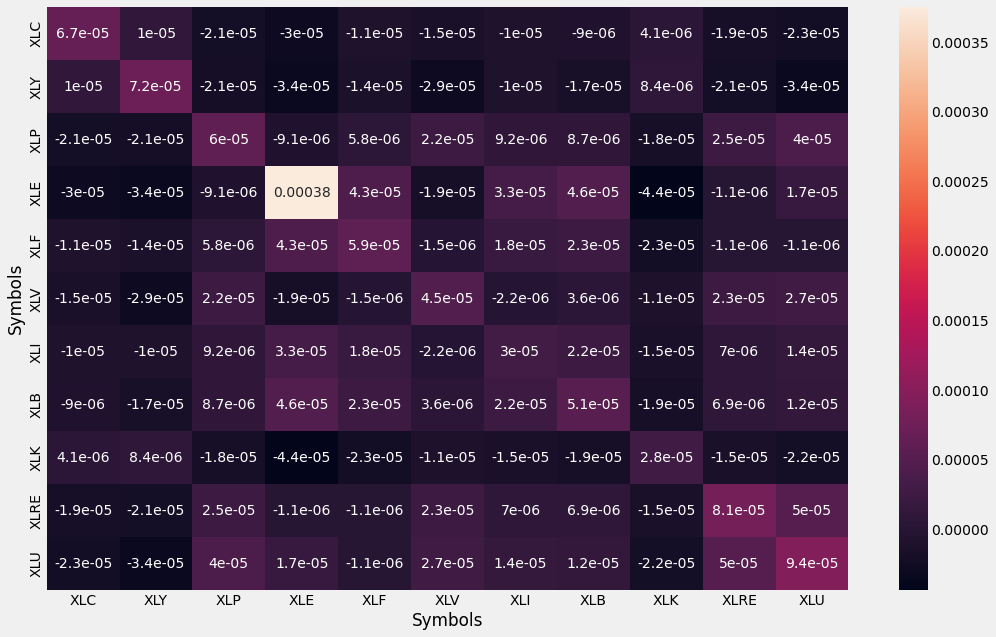


E[R]-rf
XLC    -0.001170
XLY    -0.000099
XLP     0.000340
XLE     0.002054
XLF    -0.000186
XLV     0.000139
XLI    -0.000072
XLB    -0.000095
XLK     0.000093
XLRE    0.000097
XLU     0.000588
dtype: float64


In [9]:
hedge_var_covar = hedge_df.cov()
#print("Variance - covariance matrix")
print(hedge_var_covar)
sns.heatmap(hedge_var_covar, annot= True)
plt.show()

print()
print("E[R]-rf")
print(pd.Series(alphas_list, index= symbols[:-2]))

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']
{'XLC': -0.0305, 'XLY': 0.13446, 'XLP': 0.0952, 'XLE': 0.09282, 'XLF': 0.08079, 'XLV': 0.1504, 'XLI': 0.00909, 'XLB': 0.00192, 'XLK': 0.39443, 'XLRE': -0.0138, 'XLU': 0.08521}
Expected annual return: 0.0%
Annual volatility: 0.2%
Sharpe Ratio: 0.21


C:\Users\Ben\AppData\Roaming\Python\Python39\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


<AxesSubplot:xlabel='Weight'>

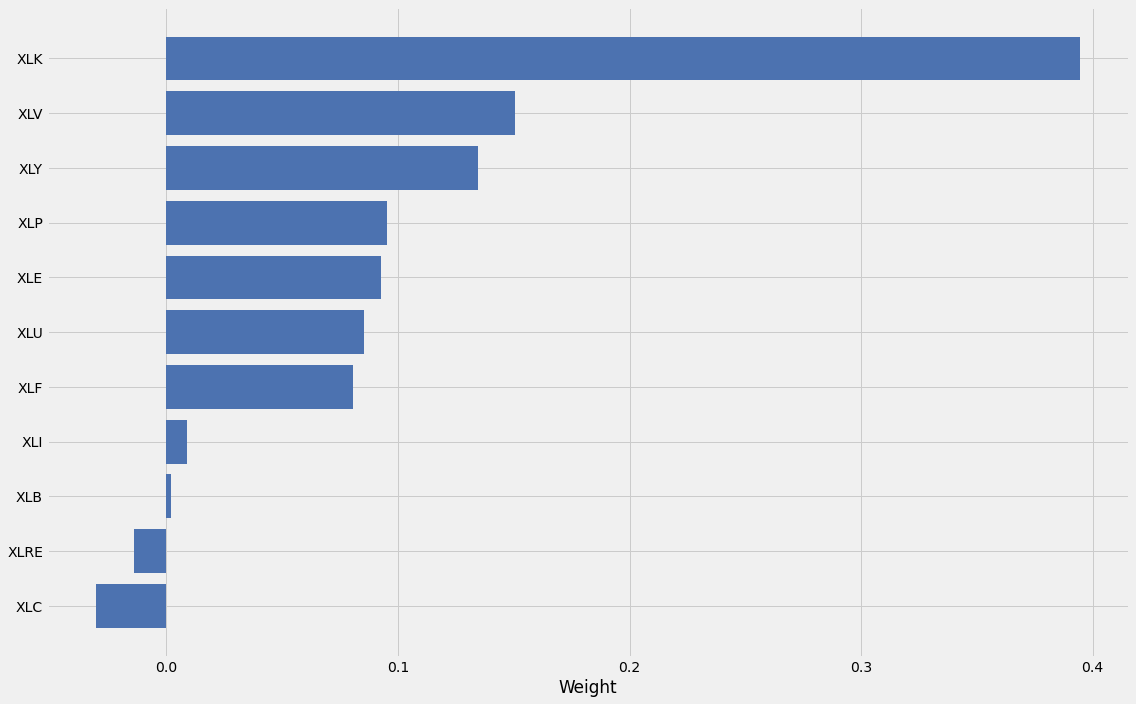

In [10]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
import cvxpy

print(cvxpy.installed_solvers())

#excess_returns = excess_std_mean_df["Mean Excess Return"].drop(["SPY", "BIL"])
#print(excess_returns)

ef = EfficientFrontier(alphas_list, hedge_var_covar, weight_bounds= (-0.2, 0.5), solver= 'ECOS_BB') # weight_bounds= (-1, 1)
weights = ef.max_sharpe(risk_free_rate= 0)
cleaned_weights = dict(ef.clean_weights())

print(cleaned_weights)
ef.portfolio_performance(verbose = True, risk_free_rate= 0)

plotting.plot_weights(cleaned_weights)

In [11]:
final_df = pd.DataFrame.from_dict(cleaned_weights, orient= 'index')
final_df.rename(columns= {0: "Weights"}, inplace= True)

#print(final_df)
#print(betas_df.columns)
#if "SPY" in betas_df.columns :
#betas_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
#print(betas_df.values)
final_df["Beta"] = betas_df.iloc[:,:-2].values.T
final_df["Market"] = final_df["Weights"]*final_df["Beta"]*-1
final_df["BIL"] = final_df["Weights"]*(final_df["Beta"]-1)

print(final_df)

sum_market = final_df["Market"].sum()
sum_bil = final_df["BIL"].sum()
print()
print("Building a dollar neutral strategy:")
print("Sum SPY: ", sum_market, "Sum BIL: ", sum_bil)
print("Sum SPY+BIL: ", sum_market+sum_bil)



      Weights      Beta    Market       BIL
XLC  -0.03050  1.107217  0.033770 -0.003270
XLY   0.13446  1.345717 -0.180945  0.046485
XLP   0.09520  0.480703 -0.045763 -0.049437
XLE   0.09282  0.627094 -0.058207 -0.034613
XLF   0.08079  0.905272 -0.073137 -0.007653
XLV   0.15040  0.633395 -0.095263 -0.055137
XLI   0.00909  0.817404 -0.007430 -0.001660
XLB   0.00192  0.855927 -0.001643 -0.000277
XLK   0.39443  1.311167 -0.517164  0.122734
XLRE -0.01380  0.754893  0.010418  0.003382
XLU   0.08521  0.391170 -0.033332 -0.051878

Building a dollar neutral strategy:
Sum SPY:  -0.9686957715824467 Sum BIL:  -0.03132422841755335
Sum SPY+BIL:  -1.0000200000000001


       Weights  Last Price       $ Amount  Number of Shares
SPY  -0.968696  419.989990 -484347.885791           -1153.2
BIL  -0.031324   91.430000  -15662.114209            -171.3
XLC  -0.030500   58.520000  -15250.000000            -260.6
XLRE -0.013800   44.779999   -6900.000000            -154.1
XLB   0.001920   79.620003     960.000000              12.1
XLI   0.009090   98.360001    4545.000000              46.2
XLF   0.080790   35.009998   40395.000000            1153.8
XLU   0.085210   75.489998   42605.000000             564.4
XLE   0.092820   77.879997   46410.000000             595.9
XLP   0.095200   74.860001   47600.000000             635.9
XLY   0.134460  166.149994   67230.000000             404.6
XLV   0.150400  131.929993   75200.000000             570.0
XLK   0.394430  147.669998  197215.000000            1335.5


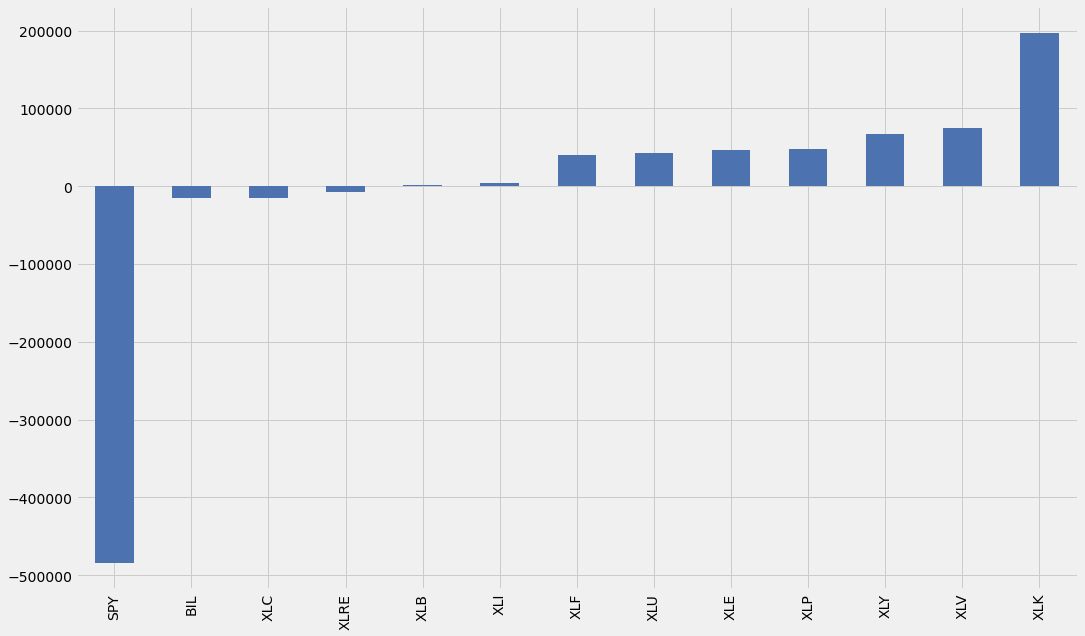

In [12]:
from pypfopt.discrete_allocation import get_latest_prices

cash_investment = 500000

hedge_weights  = cleaned_weights
hedge_weights["SPY"] = sum_market
hedge_weights["BIL"] = sum_bil

discrete_df = pd.DataFrame.from_dict(hedge_weights, orient= 'index')
discrete_df.rename(columns= {0: "Weights"}, inplace= True)
discrete_df["Last Price"] = get_latest_prices(stock_data["Adj Close"])
discrete_df["$ Amount"] = discrete_df["Weights"]*cash_investment
discrete_df["Number of Shares"] = round(discrete_df["$ Amount"]/discrete_df["Last Price"], 1)

discrete_df.sort_values(by=["$ Amount"], inplace= True)
print(discrete_df)
discrete_df["$ Amount"].plot(kind = 'bar')
plt.show()